## Image Object Detection Inference and Mask generation using Online Endpoints

This sample shows how deploy `image-object-detection` type models to an online endpoint for inference.

### Task
`image-object-detection` tasks assign box(es) with their scaled top-left and bottom-right coordinates along with box label and confidence score to an image.
 
### Model
Models that can perform the `image-object-detection` task are tagged with `image-object-detection`. We will use the `yolof_r50_c5_8x8_1x_coco` model in this notebook. If you opened this notebook from a specific model card, remember to replace the specific model name.

### Inference data
We will use the [fridgeObjects](https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip) dataset for object detection.


### Outline
1. Setup pre-requisites
2. Pick a model to deploy
3. Prepare data for inference
4. Deploy the model to an online endpoint for real time inference
5. Test the endpoint
6. Clean up resources - delete the online endpoint

### 1. Setup pre-requisites
* Install dependencies
* Connect to AzureML Workspace. Learn more at [set up SDK authentication](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk). Replace  `<WORKSPACE_NAME>`, `<RESOURCE_GROUP>` and `<SUBSCRIPTION_ID>` below.
* Connect to `azureml` system registry

In [1]:
from azure.ai.ml import MLClient
from azure.identity import (
    DefaultAzureCredential,
    InteractiveBrowserCredential,
    ClientSecretCredential,
)
from azure.ai.ml.entities import AmlCompute
import time

try:
    credential = DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    credential = InteractiveBrowserCredential()

try:
    workspace_ml_client = MLClient.from_config(credential)
    subscription_id = workspace_ml_client.subscription_id
    resource_group = workspace_ml_client.resource_group_name
    workspace_name = workspace_ml_client.workspace_name
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace_name = "<AML_WORKSPACE_NAME>"
workspace_ml_client = MLClient(
    credential, subscription_id, resource_group, workspace_name
)

# The models, fine tuning pipelines and environments are available in the AzureML system registry, "azureml"
registry_ml_client = MLClient(
    credential,
    subscription_id,
    resource_group,
    registry_name="azureml",
)
# Generating a unique timestamp that can be used for names and versions that need to be unique
timestamp = str(int(time.time()))

Found the config file in: .\config.json


### 2. Pick a model to deploy

Browse models in the Model Catalog in the AzureML Studio, filtering by the `image-object-detection` task. In this example, we use the `yolof_r50_c5_8x8_1x_coco ` model. If you have opened this notebook for a different model, replace the model name accordingly. This is a pre-trained model and may not give correct prediction for your dataset. We strongly recommend to finetune this model on a down-stream task to be able to use it for predictions and inference. Please refer to the [image object detection finetuning notebook](../../finetune/image-object-detection/mmdetection-fridgeobjects-object-detection.ipynb).

In [2]:
model_name = "yolof_r50_c5_8x8_1x_coco"
foundation_models = registry_ml_client.models.list(name=model_name)
foundation_model = max(foundation_models, key=lambda x: x.version)
print(
    f"\n\nUsing model name: {foundation_model.name}, version: {foundation_model.version}, id: {foundation_model.id} for inferencing"
)



Using model name: yolof_r50_c5_8x8_1x_coco, version: 8, id: azureml://registries/azureml/models/yolof_r50_c5_8x8_1x_coco/versions/8 for inferencing


### 3. Prepare data for inference

We will use the [odFridgeObjects](https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip) dataset for object detection.

In [3]:
import os
import urllib
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = "./data"

# Create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

# Download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"

# Extract current dataset name from dataset url
dataset_name = os.path.split(download_url)[-1].split(".")[0]
# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Download the dataset
urllib.request.urlretrieve(download_url, filename=data_file)

# Extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path=dataset_parent_dir)
    print("done")
# Delete zip file
os.remove(data_file)

extracting files...
done


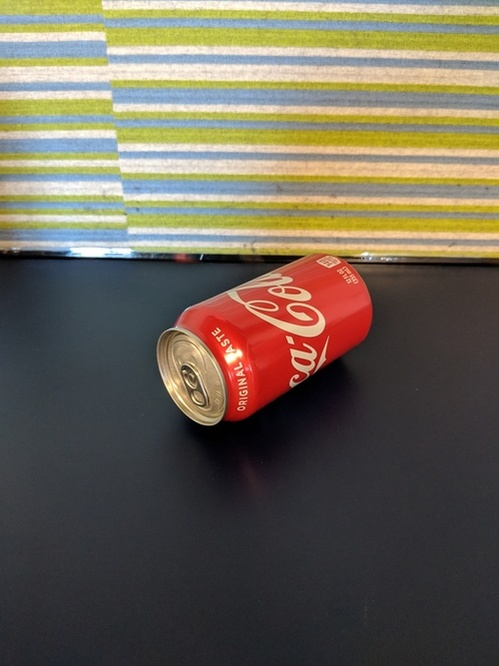

In [4]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images", "99.jpg")
Image(filename=sample_image)

### 4. Deploy the model to an online endpoint for real time inference
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

In [5]:
import time
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment

# Endpoint names need to be unique in a region, hence using timestamp to create unique endpoint name
timestamp = int(time.time())
online_endpoint_name = "mmd-image-od-" + str(timestamp)
# Create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Online endpoint for "
    + foundation_model.name
    + ", for image-object-detection task",
    auth_mode="key",
)
workspace_ml_client.begin_create_or_update(endpoint).wait()

In [6]:
from azure.ai.ml.entities import OnlineRequestSettings, ProbeSettings

deployment_name = "mmd-image-od-mlflow-deploy"

print(foundation_model.id)
print(online_endpoint_name)
print(deployment_name)

# Create a deployment
demo_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=foundation_model.id,
    instance_type="Standard_DS3_v2",  # Use GPU instance type like Standard_NC6s_v3 for faster inference
    instance_count=1,
    request_settings=OnlineRequestSettings(
        max_concurrent_requests_per_instance=1,
        request_timeout_ms=90000,
        max_queue_wait_ms=500,
    ),
    liveness_probe=ProbeSettings(
        failure_threshold=49,
        success_threshold=1,
        timeout=299,
        period=180,
        initial_delay=180,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=10,
    ),
)
workspace_ml_client.online_deployments.begin_create_or_update(demo_deployment).wait()
endpoint.traffic = {deployment_name: 100}
workspace_ml_client.begin_create_or_update(endpoint).result()

Check: endpoint mmd-image-od-1701143743 exists


azureml://registries/azureml/models/yolof_r50_c5_8x8_1x_coco/versions/8
mmd-image-od-1701143743
mmd-image-od-mlflow-deploy
..............................................................

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://mmd-image-od-1701143743.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://mmd-image-od-1701143743.eastus.inference.ml.azure.com/swagger.json', 'name': 'mmd-image-od-1701143743', 'description': 'Online endpoint for yolof_r50_c5_8x8_1x_coco, for image-object-detection task', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/resourceshubham/providers/microsoft.machinelearningservices/workspaces/shubham-soni-workspace/onlineendpoints/mmd-image-od-1701143743', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:2dec82da-7ab1-4118-8344-7bb0815cf984:d2c8a48a-001c-43e5-b7f4-7418519ccd09?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscri

### 5. Test the endpoint

We will fetch some sample data from the test dataset and submit to online endpoint for inference.

In [7]:
demo_deployment = workspace_ml_client.online_deployments.get(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
)

# Get the details for online endpoint
endpoint = workspace_ml_client.online_endpoints.get(name=online_endpoint_name)

# Existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)
print(demo_deployment)

{'mmd-image-od-mlflow-deploy': 100}
https://mmd-image-od-1701143743.eastus.inference.ml.azure.com/score
app_insights_enabled: false
egress_public_network_access: enabled
endpoint_name: mmd-image-od-1701143743
environment_variables: {}
id: /subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/resourceshubham/providers/Microsoft.MachineLearningServices/workspaces/shubham-soni-workspace/onlineEndpoints/mmd-image-od-1701143743/deployments/mmd-image-od-mlflow-deploy
instance_count: 1
instance_type: Standard_DS3_v2
liveness_probe:
  failure_threshold: 49
  initial_delay: 180
  period: 180
  success_threshold: 1
  timeout: 299
model: azureml://registries/azureml/models/yolof_r50_c5_8x8_1x_coco/versions/8
name: mmd-image-od-mlflow-deploy
properties:
  AzureAsyncOperationUri: https://management.azure.com/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/od:2dec82da-7ab1-4118-8344-7bb0815cf984:ffdc475d

In [8]:
# Create request json
import base64
import json

sample_image = os.path.join(dataset_dir, "images", "99.jpg")


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "index": [0],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [10]:
# Score the sample_score.json file using the online endpoint with the azureml endpoint invoke method
resp = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=demo_deployment.name,
    request_file=request_file_name,
)
print(f"raw response: {resp}\n")

raw response: [{"boxes": [{"box": {"topX": 0.29855089818308495, "topY": 0.368856183759443, "bottomX": 0.7655488589483654, "bottomY": 0.6487778214005021}, "label": "person", "score": 0.07349181175231934}, {"box": {"topX": 0.29855089818308495, "topY": 0.368856183759443, "bottomX": 0.7655488589483654, "bottomY": 0.6487778214005021}, "label": "bicycle", "score": 0.058834657073020935}, {"box": {"topX": 0.31230074895885523, "topY": 0.3728017950201178, "bottomX": 0.7628521814136084, "bottomY": 0.6507991298182949}, "label": "car", "score": 0.08457841724157333}, {"box": {"topX": 0.0, "topY": 0.19419095609281156, "bottomX": 1.0, "bottomY": 0.8151163553690409}, "label": "car", "score": 0.05055837333202362}, {"box": {"topX": 0.29855089818308495, "topY": 0.368856183759443, "bottomX": 0.7655488589483654, "bottomY": 0.6487778214005021}, "label": "motorcycle", "score": 0.051231831312179565}, {"box": {"topX": 0.31230074895885523, "topY": 0.3728017950201178, "bottomX": 0.7628521814136084, "bottomY": 0.6

### 6. Invoke the SAM endpoint on the same image with bounding box as a prompt to get the segmentation mask.


bed 1: [0.612, 0.501, 498.388, 259.786], 0.202
bottle 1: [158.874, 252.731, 217.595, 175.839], 0.196
stop sign 1: [160.562, 251.702, 215.31, 174.026], 0.193
dining table 1: [0.0, 66.007, 499.0, 563.864], 0.161
truck 1: [148.911, 246.335, 233.173, 185.801], 0.135
cup 1: [155.838, 248.286, 224.825, 185.146], 0.132
[array([0.13478716, 0.18981278, 0.80500047]), array([0.58290695, 0.98673244, 0.51573934]), array([0.63251814, 0.94601127, 0.72248359]), array([0.7402096 , 0.07631881, 0.27863338]), array([0.45677215, 0.86860073, 0.49020939]), array([0.90157677, 0.57176766, 0.72774823])]


C:\Users\sonishubham\AppData\Local\Temp\ipykernel_16172\630376076.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


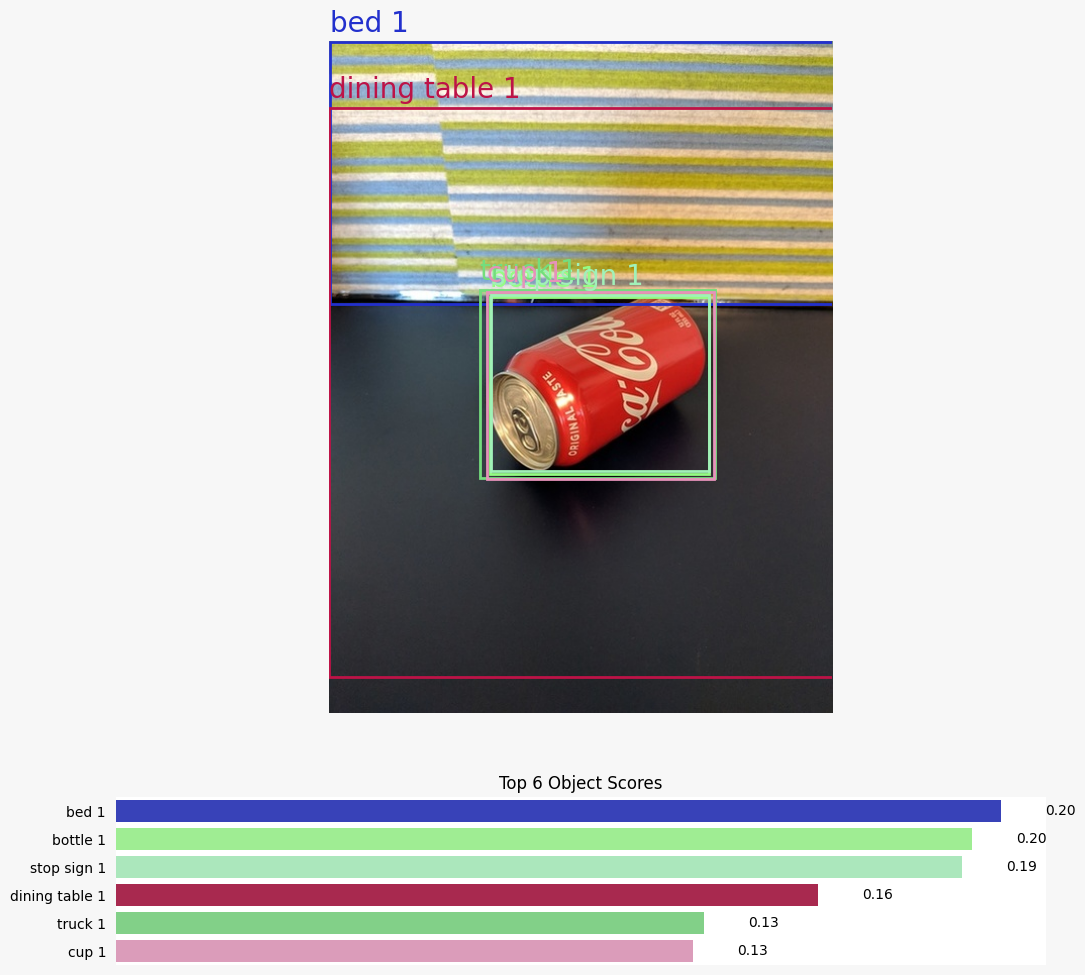

In [10]:
%matplotlib inline
import json
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size
conf_threshold = 0.1  # display top objects with confidence score > 0.6

# Set a compact figure size
fig_width = 12
fig_height = 12

# Initialize figure and axes
fig = plt.figure(figsize=(fig_width, fig_height))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Display the image with bounding boxes and segmentation maps
ax1.imshow(img_np)
ax1.axis("off")

# Draw bounding boxes and segmentation maps for each detection
detections = json.loads(resp)
sorted_data = sorted(detections[0]["boxes"], key=lambda x: x["score"], reverse=True)
sorted_scores = []
sorted_colors = []
unique_labels = []
label_counter = {}

Boxes = []
# draw box and label for each detection
for detect in sorted_data:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]

    if conf_score > conf_threshold:
        # Modify labels to make them unique with numbering
        if label not in label_counter:
            label_counter[label] = 1
            unique_labels.append(f"{label} {label_counter[label]}")
        else:
            label_counter[label] += 1
            unique_labels.append(f"{label} {label_counter[label]}")

        current_label = unique_labels[-1]

        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            f"{current_label}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
            f"{round(width, 3)}, {round(height, 3)}], {round(conf_score, 3)}"
        )
        
        Boxes.append([xmin*x, ymin*y, xmax*x, ymax*y, conf_score])
        

        color = np.random.rand(3)
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax1.add_patch(rect)
        ax1.text(topleft_x, topleft_y - 10, current_label, color=color, fontsize=20)
        sorted_scores.append(conf_score)
        sorted_colors.append(color)

# Set a stylish color palette
sns.set_palette("pastel")
print(sorted_colors)
# Create the bar plot without x-axis and y-axis markings
barplot = sns.barplot(x=sorted_scores, y=unique_labels, palette=sorted_colors, ax=ax2)
ax2.set_xlabel("")  # Remove x-axis label
ax2.set_ylabel("")  # Remove y-axis label
ax2.set_title(f"Top {len(sorted_scores)} Object Scores", fontsize=12)

# Add scores in front of the bars
for index, value in enumerate(sorted_scores):
    barplot.text(
        value + 0.01, index, f"{value:.2f}", va="center", color="black", fontsize=10
    )

# Remove spines and ticks from the bar plot
barplot.spines["left"].set_visible(False)
barplot.spines["top"].set_visible(False)
barplot.spines["right"].set_visible(False)
barplot.spines["bottom"].set_visible(False)
barplot.tick_params(left=False, top=False, right=False, bottom=False)
barplot.xaxis.set_visible(False)  # Remove x-axis
barplot.yaxis.grid(False)  # Remove y-axis grid

# Set plot background color
fig.patch.set_facecolor("#F7F7F7")  # Light gray

plt.tight_layout()
# fig.savefig("plot.png", bbox_inches="tight")
plt.show()

In [18]:
B= sorted(Boxes,key = lambda x:x[4])
print(B[0])


[155.83807373046875, 248.28599548339844, 380.6632385253906, 433.43222045898443, 0.13205622136592865]


In [23]:
import base64
import json

sample_image = os.path.join(dataset_dir, "images", "99.jpg")


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

a,b,c,d = str(B[0][0]), str(B[0][1]), str(B[0][2]), str(B[0][3])

request_json = {
    "input_data": {
        "columns": [
            "image",
            "input_points",
            "input_boxes",
            "input_labels",
            "multimask_output",
        ],
        "index": [0],
        "data": [
            # segmentation mask per input point
            [
                base64.encodebytes(read_image(sample_image)).decode("utf-8"),
                "",
                f"[[{a},{b},{c},{d}]]",

                "",
                False,
            ],
        ],
    }
}

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [24]:
# Score the sample_score.json file using the online endpoint with the azureml endpoint invoke method
response = workspace_ml_client.online_endpoints.invoke(
    endpoint_name="shubham-soni-workspace-sam",
    deployment_name="facebook-sam-vit-huge-1",
    request_file=request_file_name,
)

print(f"raw response: {response}\n")

raw response: [{"response": {"predictions": [{"masks_per_prediction": [{"encoded_binary_mask": "iVBORw0KGgoAAAANSUhEUgAAAfMAAAKaCAAAAAAPd++YAAAFvklEQVR4nO3awXIbNxREUTiV//9lZxGVy4lkipwZEN2Yc5ZJFsC7eiCj0hgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADn/Fh9gF4/xxiVAyw8coKfX/3Dllm2nDPJl8E/NMyz4YxRHgX/V/xI4w+Y5fviI3+m6edL8lTwMUb6VLNPl+T54mNkzzX5bEleKz7GCB5t7MGSHAg+Ru5sU88V5GDxETvc0GPFOB58jNTpZp4qxLngY4zM+SaeKcQFxUfkgAOPlOGa4iNxwnkninBZ8RE44rgDJbiy+Mibcdp51rs4+BhxQw47znITio+0Kf+9+gBR5hRPk/UTuNTM4FFjjjrMSpNXPGnO3vYxxl0e9Q9JP3+rvCV40KCDjrLIu1Y8Z9I5J1njjY96zKjv/Xl+q4/xX2J++BZ4d/GUWaec4+1WrHjIsG/6tt/zUf9wy+a3Lh7z3LzRyuAZ0844xfssXvGIcd/rbb/5o/4h4gfvTRKKJ8z7PnueUDzDTZoL/puEt2a6pOIBA7/BnicVj7B9c8U/CXhqZgosvn7iO+95YPAI63/qZoktvnzkm+55bPAEf60+wBSSP7Ljniv+2PIPl6sVBF898832vKD4ejs1F/w5+zRX/Fm7NFf8eVs0F/wlq79DXqCv+OKht+95X/D1upsrfkRzc8WPKf59u+QH9TaX/Kja5pIf1tpc8uNKm0t+Qmdzyc+obC75KZXNOaWx

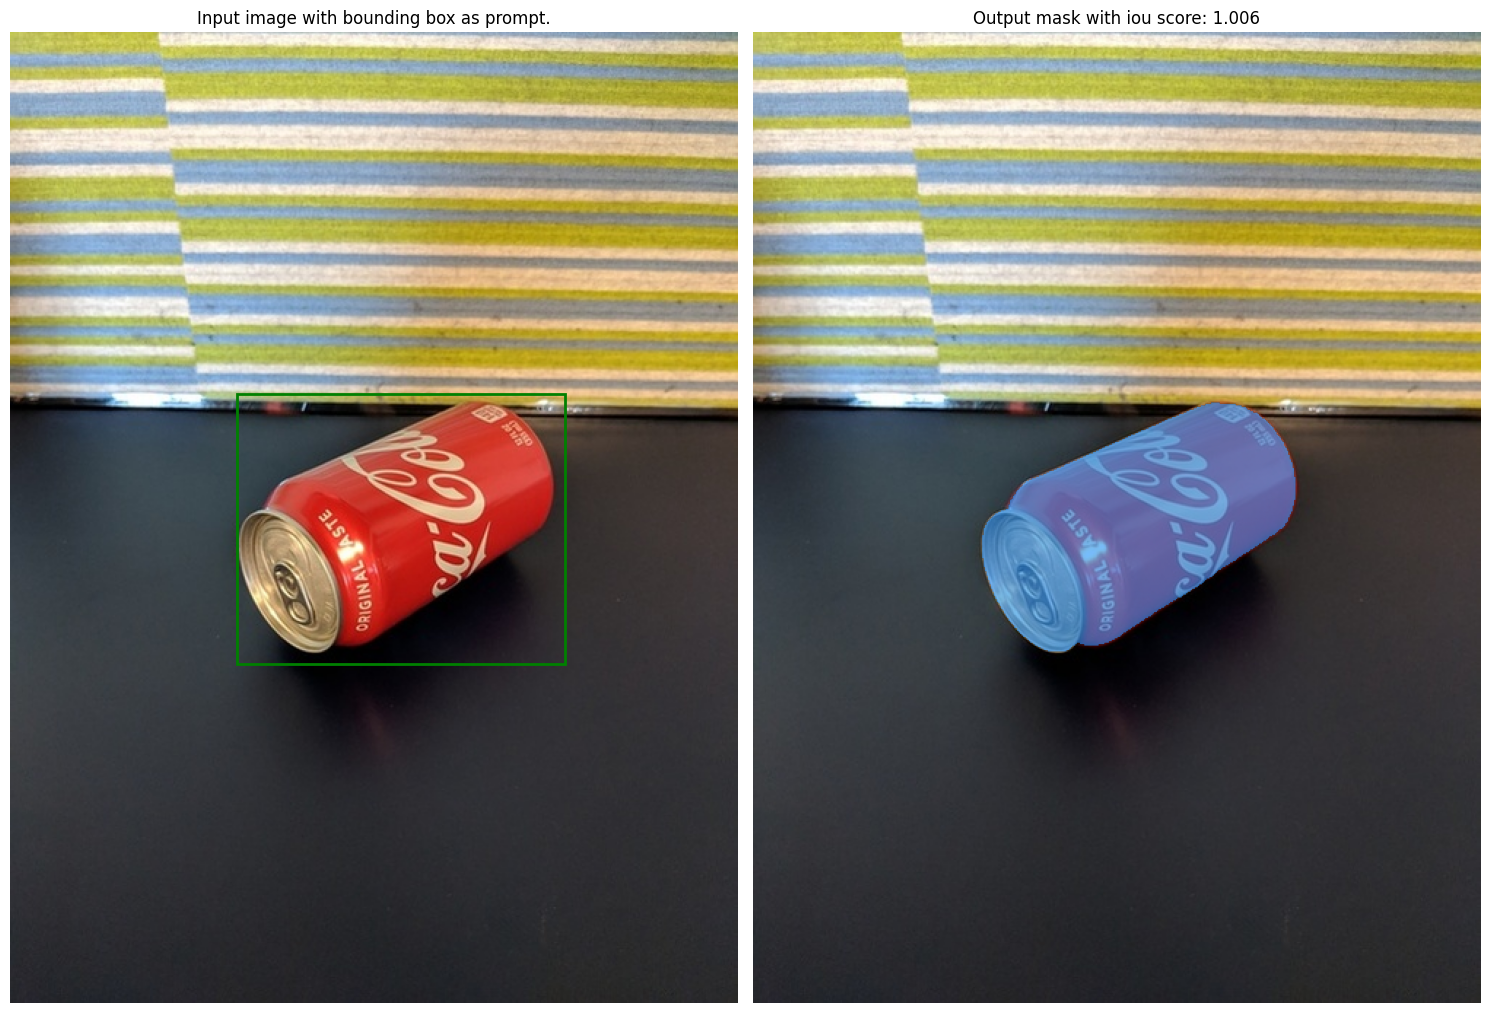

In [26]:
# visualize sample input bounding box as prompt and output mask
import io
import base64
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_mask(mask, ax, random_color=False):
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
        mask = mask > 0
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


df_from_json = pd.read_json(response)
encoded_mask = df_from_json["response"][0]["predictions"][0]["masks_per_prediction"][0][
    "encoded_binary_mask"
]
mask_iou = df_from_json["response"][0]["predictions"][0]["masks_per_prediction"][0][
    "iou_score"
]

# Load the sample image
img = Image.open(io.BytesIO(base64.b64decode(encoded_mask)))
raw_image = Image.open(sample_image).convert("RGB")

# Display the original image and bounding box
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(np.array(raw_image))
show_box([155, 248, 380, 433], axes[0])
axes[0].title.set_text(f"Input image with bounding box as prompt.")
axes[0].axis("off")

axes[1].imshow(np.array(raw_image))
show_mask(img, axes[1])
axes[1].title.set_text(f"Output mask with iou score: {mask_iou:.3f}")
axes[1].axis("off")
# Adjust the spacing between subplots
fig.tight_layout()
plt.show()